In [40]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import import_ipynb
import os
import warnings

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STconvolve

In [2]:
def Gaussain1d(x, x0, sigma, a):
    return a*np.exp(-((x - x0)/sigma)**2/2) / (sigma*np.sqrt(np.pi*2))

def DoG(x, x0, sigma1, sigma2, a1, a2):
    return Gaussain1d(x, x0, sigma1, a1)-Gaussain1d(x, x0, sigma2, a2)

def stf(t, tau, a):
    return a*np.exp(-t/tau)*t / tau**2

def DoE(t, tau1, tau2, a1, a2):
    return stf(t, tau1, a1) - stf(t, tau2, a2)

# Main

In [21]:
xaxis = np.arange(-5000,5000+1) #unit = L #dx = 1
dt = 0.001 #unit = s
taxis = np.arange(0,0.8,dt) #unit = s

sigma1 = 250
sigma2 = 5*sigma1
tau1 = 0.06
tau2 = 0.07

SKon = Gaussain1d(xaxis, 0, sigma1, 1)
SKoff = Gaussain1d(xaxis, 0, sigma2, 1)
TKon = stf(taxis, tau1, 1)
TKoff = stf(taxis, tau2, 1.05)

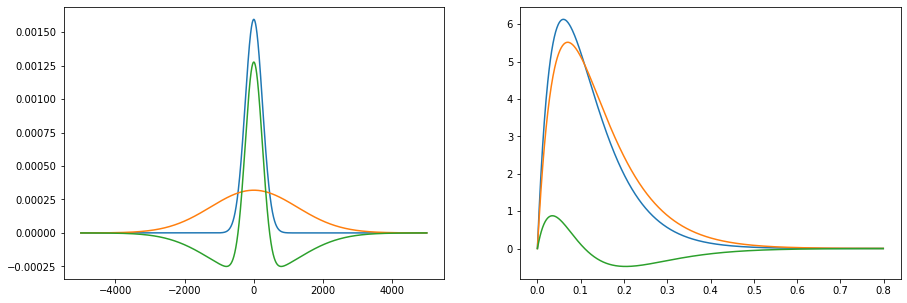

In [22]:
fig, ax = plt.subplots(1,2)
ax[0].plot(xaxis, SKon)
ax[0].plot(xaxis, SKoff)
ax[0].plot(xaxis, SKon-SKoff)

ax[1].plot(taxis, TKon)
ax[1].plot(taxis, TKoff)
ax[1].plot(taxis, TKon-TKoff)

plt.gcf().set_size_inches(15, 5)

In [23]:
Kset0 = TKon[:, np.newaxis]*SKon[np.newaxis,:] - TKoff[:, np.newaxis]*SKoff[np.newaxis,:]
# Kset1 = TKon[:, np.newaxis]*SKoff[np.newaxis,:] + TKoff[:, np.newaxis]*SKon[np.newaxis,:]
Kset2 = (TKon-TKoff)[:, np.newaxis]*(SKon-SKoff)[np.newaxis,:]

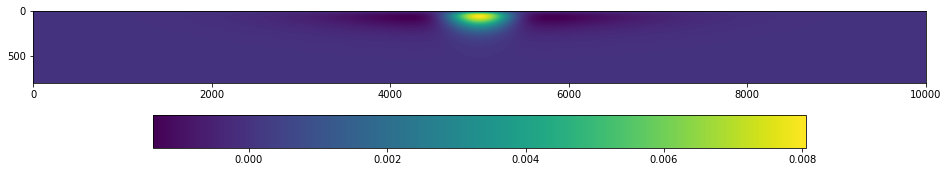

In [24]:
plt.imshow(Kset0)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(16, 4)

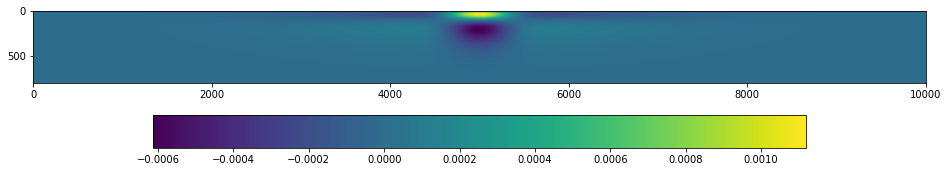

In [25]:
plt.imshow(Kset2)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(16, 4)

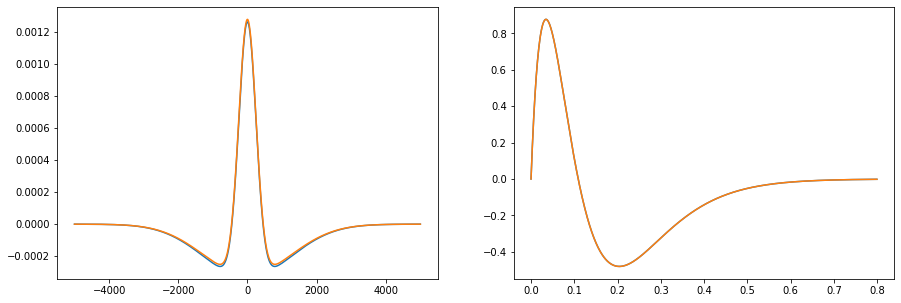

In [26]:
fig, ax = plt.subplots(1,2)
ax[0].plot(xaxis, np.sum(Kset0, axis =0)*dt)
# ax[0].plot(xaxis, np.sum(Kset1, axis =0))
ax[0].plot(xaxis, SKon-SKoff)

ax[1].plot(taxis, np.sum(Kset0, axis =1))
# ax[1].plot(taxis, np.sum(Kset1, axis =1))
ax[1].plot(taxis, TKon-TKoff)

plt.gcf().set_size_inches(15, 5)

# SVD

In [27]:
from numpy import linalg as la
U,sigma,VT=la.svd(Kset0)

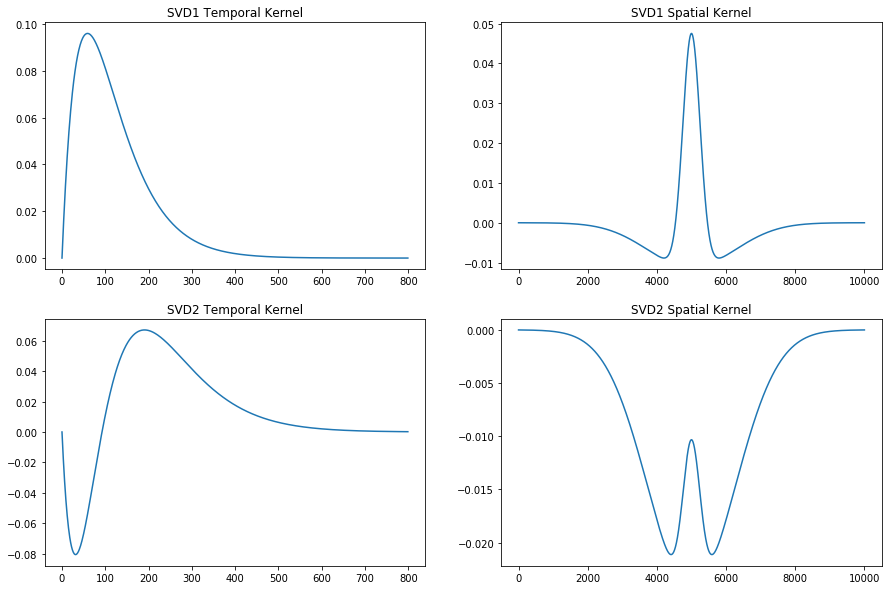

In [28]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

In [29]:
(sigma/sum(sigma))[:2]

array([0.93497384, 0.06502616])

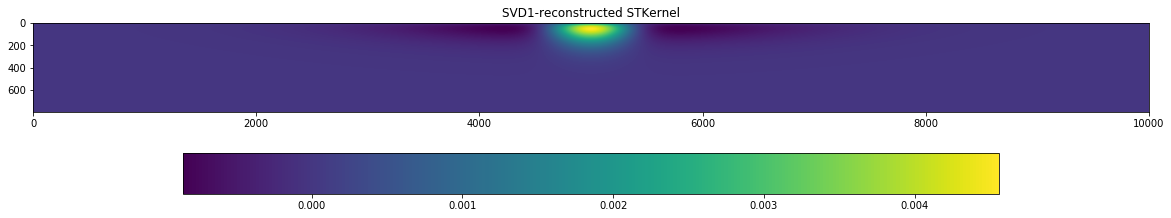

In [30]:
cSVD = 0
SVD_STkernel = U[:,cSVD][:, np.newaxis]* VT[cSVD,:][np.newaxis, :]
plt.imshow(SVD_STkernel)
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
plt.colorbar(orientation="horizontal")
fig = plt.gcf()
fig.set_size_inches(20, 5)

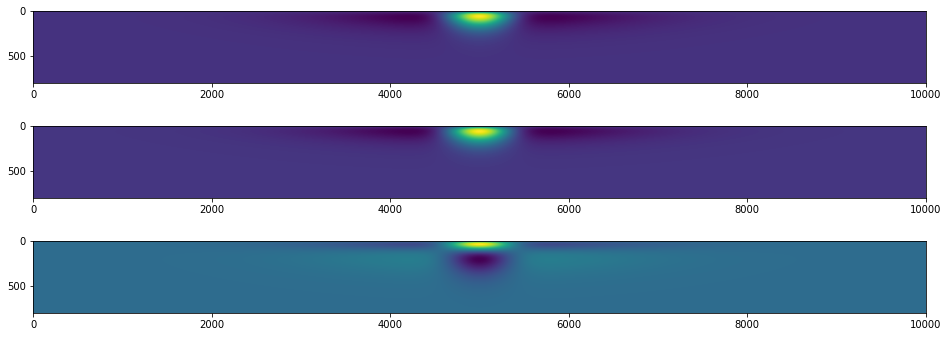

In [31]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(Kset0)
ax[1].imshow(SVD_STkernel)
ax[2].imshow(Kset2)
plt.gcf().set_size_inches(16, 6)

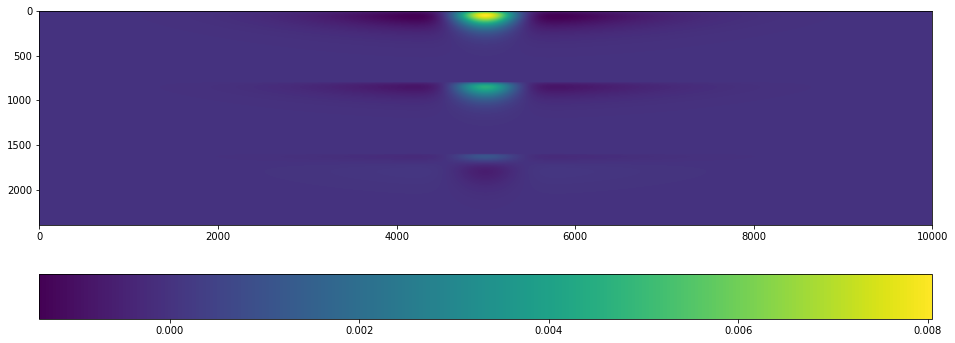

In [32]:
plt.imshow(np.vstack((Kset0, SVD_STkernel, Kset2)))
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(16, 6)

## fitting

[2.75392734e-08 2.49999994e+02 1.25000000e+03 3.68797091e+01
 3.54531068e+01]


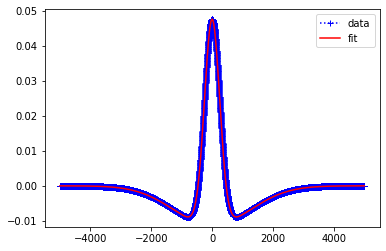

In [33]:
SK =VT[0,:]

a = max(SK)*np.sqrt(2*np.pi)*sigma1
popt,pcov = curve_fit(DoG, xaxis, SK, p0=[0, sigma1, sigma2, a, a], bounds= (0, np.inf))
# popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)

plt.plot(xaxis, SK, 'b+:', label='data')
plt.plot(xaxis,  DoG(xaxis, *popt), 'r-', label='fit')
plt.legend()

[0.06233661 0.0623938  1.00773895 0.99242315]


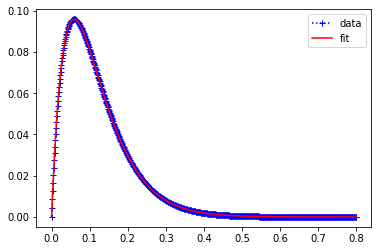

In [34]:
TK = U[:,0]
# DoE(t, tau1, tau2, a1, a2)
# a = max(SK)*np.sqrt(2*np.pi)*sigma1
popt,pcov = curve_fit(DoE, taxis, TK, p0=[tau1, tau2, 1, 1], bounds= (0, np.inf))
# popt,pcov = curve_fit(DoG, space_window, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)

plt.plot(taxis, TK, 'b+:', label='data')
plt.plot(taxis,  DoE(taxis, *popt), 'r-', label='fit')
plt.legend()

# Motion Prediction 

In [47]:
v = 1 #xstep per tstep #1.5 in berry1999
MB = np.eye(10001,10001)

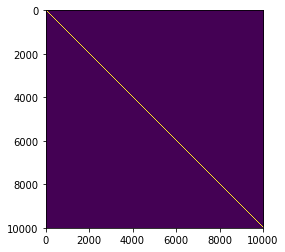

In [48]:
plt.imshow(MB)

In [51]:
mb_y = STconvolve(MB[5000:6000:10,:],Kset0[::10,1000:-1000],1,dt*10)

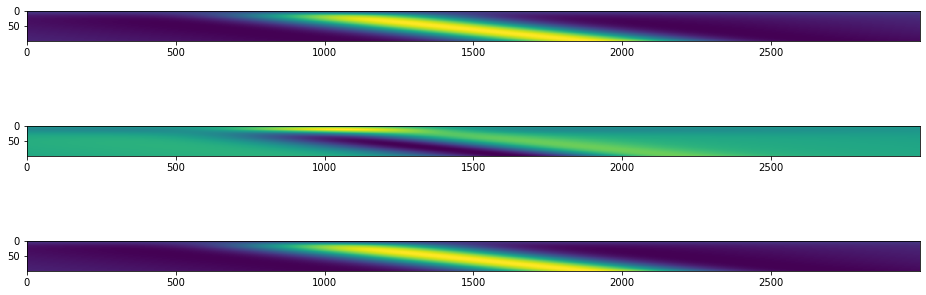

In [66]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(mb_y[:,4000:7000])
ax[1].imshow(mb_y2[:,4000:7000])
ax[2].imshow(mb_ysvd[:,4000:7000])
plt.gcf().set_size_inches(16, 6)

In [58]:
mb_y2 = STconvolve(MB[5000:6000:10,:],Kset2[::10,1000:-1000],1,dt*10)
mb_ysvd = STconvolve(MB[5000:6000:10,:],SVD_STkernel[::10,1000:-1000],1,dt*10)

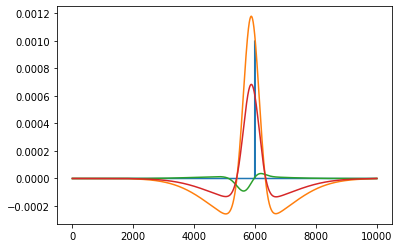

In [61]:
ip = MB[5000:6000:10,:]
plt.plot(ip[-1,:]*0.001)
plt.plot(mb_y[-1,:])
plt.plot(mb_y2[-1,:])
plt.plot(mb_ysvd[-1,:])

In [69]:
def Deltaaddtion(x,barwid):
    y = np.zeros(len(x)-barwid)
    for bw in range(barwid):
        y += x[bw:-barwid+bw]
    return y

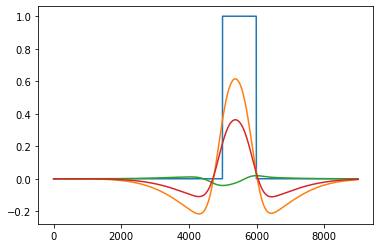

In [77]:
ip = MB[5000:6000:10,:]
plt.plot(Deltaaddtion(ip[-1,:]*0.001*1000,1000))
plt.plot(Deltaaddtion(mb_y[-1,:],1000))
plt.plot(Deltaaddtion(mb_y2[-1,:],1000))
plt.plot(Deltaaddtion(mb_ysvd[-1,:],1000))